In [1]:
import pandas, seaborn, scipy, numpy, matplotlib, sklearn, collections, itertools, math, functools, sys

%matplotlib inline
from matplotlib import pyplot
matplotlib.rc("savefig", dpi=800)
#matplotlib.rc("savefig", dpi=72)

from sklearn import preprocessing

# Constants
library_sizes = {
    'WGS': 3002000000,
    'WES': 50160183,
}
mhc_binding_threshold_affinity = 500

def bootstrap(values, statistic=numpy.mean, samples=5000):
    values = pandas.Series(values).dropna()
    if len(values) <= 1:
        return (numpy.nan, numpy.nan)
    values = [statistic(sklearn.utils.resample(values)) for i in range(samples)]
    return (numpy.percentile(values, 5), numpy.percentile(values, 95))

def round_to_n(x, n):
    return round(x, -int(math.floor(math.log10(x))) + (n - 1)) 

def mean_with_errorbars(values, decimals=0):
    pattern = "%%0.%df" % decimals
    bars = bootstrap(values)
    if numpy.nan in bars:
        return pattern % numpy.mean(values)
    if decimals == 0:
        bars = (round_to_n(bars[0], 2), round_to_n(bars[1], 2)) 
    return (pattern + " (" + pattern + " - " + pattern + ")") % ((numpy.mean(values),) + bars)

pandas.set_option('display.max_columns', 500)


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

/Users/tim/miniconda3/envs/py3k/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
model_inputs = {}

In [3]:
def canonicalize(x):
    (first, second) = x.split(">")
    assert len(first) == len(second) == 3
    assert first[0] == second[0]
    assert first[2] == second[2]
    return "%s[%s>%s]%s" % (first[0], first[1], second[1], first[2])

chicken_counts_df = pandas.read_csv("../data/chicken_mutation_counts_trinucleotide.csv", skiprows=4).dropna()
del chicken_counts_df["Clone"]
del chicken_counts_df["Total"]
chicken_counts_df.columns = ["Treatment"] + [canonicalize(x) for x in chicken_counts_df.columns[1:]]
context_columns = list(chicken_counts_df.columns[1:])
chicken_counts_df

for treatment in ['cisplatin', 'cyclophosphamide', 'etoposide']:
    combined_df = chicken_counts_df.ix[chicken_counts_df.Treatment.isin(["mock", treatment])].copy()
    treated_series = combined_df.Treatment == treatment
    del combined_df["Treatment"]

    data = {
        'num_sources': combined_df.shape[0],
        'num_contexts': combined_df.shape[1],
        'counts': combined_df.values.astype(int),
        'treated': treated_series.values.astype(int),
    }
    model_inputs['chicken %s' % treatment] = data
model_inputs.keys()

dict_keys(['chicken cisplatin', 'chicken etoposide', 'chicken cyclophosphamide'])

In [4]:
worm_raw_df = pandas.read_csv("../data/c_elegans_substitutions.csv")
worm_raw_df["context_mutation_3p5p"] = (
    worm_raw_df.CONTEXT.str.slice(2, 3)
    + "[" + worm_raw_df.MUT_TYPE + "]"
    + worm_raw_df.CONTEXT.str.slice(4, 5))
worm_raw_df = worm_raw_df.ix[(worm_raw_df.Drug.isin(["None", "Cisplatin"]))]
worm_counts_df = (
    worm_raw_df.groupby(["Genotype", "Drug", "Concentration", "ID", "context_mutation_3p5p"])
    .Genotype.count().unstack('context_mutation_3p5p')
    .fillna(0))
assert all(c in context_columns for c in worm_counts_df.columns)
worm_counts_df = worm_counts_df.T.ix[context_columns].T.fillna(0)
worm_counts_df = worm_counts_df.reset_index()
worm_counts_df["treated"] = worm_counts_df.Concentration > 0
treated_genotypes = worm_counts_df.groupby(["Genotype"]).treated.nunique() > 1
worm_counts_df = worm_counts_df.ix[worm_counts_df.Genotype.isin(
        list(treated_genotypes.index[treated_genotypes]))]
worm_counts_df["Treatment"] = [
    "mock" if not row.treated else "%s" % (row.Drug,)
    for (i, row) in worm_counts_df.iterrows()
]
worm_counts_df = worm_counts_df[["Genotype", "Treatment"] + context_columns]
worm_counts_df

context_mutation_3p5p,Genotype,Treatment,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,G[C>T]A,G[C>T]C,G[C>T]G,G[C>T]T,T[C>T]A,T[C>T]C,T[C>T]G,T[C>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,C[T>A]A,C[T>A]C,C[T>A]G,C[T>A]T,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,N2,Cisplatin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,N2,Cisplatin,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,N2,Cisplatin,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,N2,Cisplatin,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,N2,Cisplatin,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,N2,mock,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,N2,mock,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,N2,mock,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,N2,mock,0.0,

In [5]:
for (genotype, sub_worm_df) in worm_counts_df.groupby("Genotype"):
    sub_worm_df = sub_worm_df.copy()
    del sub_worm_df["Genotype"]
    for treatment in ["Cisplatin"]:
        combined_df = sub_worm_df.ix[sub_worm_df.Treatment.isin(["mock", treatment])].copy()
        treated_series = combined_df.Treatment == treatment
        del combined_df["Treatment"]

        data = {
            'num_sources': combined_df.shape[0],
            'num_contexts': combined_df.shape[1],
            'counts': combined_df.values.astype(int),
            'treated': treated_series.values.astype(int),
        }
        model_inputs['worm %s %s' % (genotype, treatment)] = data
model_inputs.keys()

dict_keys(['worm slx-1 Cisplatin', 'chicken cisplatin', 'worm fan-1 Cisplatin', 'chicken etoposide', 'chicken cyclophosphamide', 'worm polq-1 Cisplatin', 'worm xpf-1 Cisplatin', 'worm lig-4 Cisplatin', 'worm fcd-2 Cisplatin', 'worm lig-4; fcd-2 Cisplatin', 'worm N2 Cisplatin', 'worm mus-81 Cisplatin'])

In [3]:
import copy
#model_inputs["worm any Cisplatin"]  #['counts'].shape


In [7]:
combined = None
for key in [m for m in model_inputs if "worm" in m and "Cisplatin" in m]:
    print(key)
    if combined is None:
        combined = copy.deepcopy(model_inputs[key])
    else:
        combined['counts'] = numpy.append(combined['counts'], model_inputs[key]['counts'], axis=0)
        combined['num_sources'] += model_inputs[key]['num_sources']
        combined['treated'] = numpy.append(combined['treated'], model_inputs[key]['treated'], axis=0)

combined
        
model_inputs["worm Cisplatin"] = combined
    

worm slx-1 Cisplatin
worm fan-1 Cisplatin
worm polq-1 Cisplatin
worm xpf-1 Cisplatin
worm lig-4 Cisplatin
worm fcd-2 Cisplatin
worm lig-4; fcd-2 Cisplatin
worm N2 Cisplatin
worm mus-81 Cisplatin


In [8]:
dict((k, model_inputs[k]['counts'].sum()) for k in model_inputs)

{'chicken cisplatin': 2633,
 'chicken cyclophosphamide': 958,
 'chicken etoposide': 482,
 'worm Cisplatin': 784,
 'worm N2 Cisplatin': 111,
 'worm fan-1 Cisplatin': 44,
 'worm fcd-2 Cisplatin': 86,
 'worm lig-4 Cisplatin': 89,
 'worm lig-4; fcd-2 Cisplatin': 75,
 'worm mus-81 Cisplatin': 44,
 'worm polq-1 Cisplatin': 63,
 'worm slx-1 Cisplatin': 53,
 'worm xpf-1 Cisplatin': 219}

In [9]:
import pystan, time
FIT_CACHE={}
def run_stan(model_code, *args, **kwargs):
    kwargs = dict(kwargs)
    kwargs['model_code'] = model_code
    if 'n_jobs' not in kwargs:
        kwargs['n_jobs'] = -1
    if model_code in FIT_CACHE:
        print("Reusing fit.")
        kwargs['fit'] = FIT_CACHE[model_code]
    else:
        print("NOT reusing fit.")
    start = time.time()
    FIT_CACHE[model_code] = pystan.stan(*args, **kwargs)
    print("Ran in %0.3f sec." % (time.time() - start))
    return FIT_CACHE[model_code]



In [10]:
# stan model
model1 = """
data {
    // Data sizes
    int<lower=0> num_sources;
    int<lower=0> num_contexts;

    // Data
    int<lower=0> counts[num_sources, num_contexts];
    int<lower=0,upper=1> treated[num_sources];
}
parameters {
    vector<lower=0>[num_contexts] untreated_rates;
    vector<lower=0>[num_contexts] treated_rates;
}
model {
    for (i in 1:num_sources) {
        counts[i] ~ poisson(untreated_rates + treated[i] * treated_rates);
    }
}
""".strip()

def init(data):
    return {
        'untreated_rates': numpy.ones(len(context_columns), dtype=int),
        'treated_rates': numpy.ones(len(context_columns), dtype=int),
    }

for (i, line) in enumerate(model1.split("\n")):
    print("%3d %s" % (i + 1, line))

def print_dict(d):
    for key in [key for key in d if not isinstance(d[key], numpy.ndarray)]:
        print("%s: %s" % (key, d[key]))
    for key in [key for key in d if isinstance(d[key], numpy.ndarray)]:
        print("%s: %s mean=%s std=%s" % (key,  d[key].shape, d[key].mean(), d[key].std()))

fit_results = {}
for (label, data) in model_inputs.items():
    print("+" * 40)
    print("RUNNING MODEL FOR: %s" % label)
    print("")
    print("*" * 40)
    print("DATA")
    print_dict(data)
    print("")

    print("*" * 40)
    print("INITIAL VALUES")
    print_dict(init(data))
    sys.stdout.flush()
    
    fit_results[label] = run_stan(model_code=model1, data=data, init=lambda: init(data), iter=2000, chains=2)
    print("Done with fit.")
print("DONE")


  1 data {
  2     // Data sizes
  3     int<lower=0> num_sources;
  4     int<lower=0> num_contexts;
  5 
  6     // Data
  7     int<lower=0> counts[num_sources, num_contexts];
  8     int<lower=0,upper=1> treated[num_sources];
  9 }
 10 parameters {
 11     vector<lower=0>[num_contexts] untreated_rates;
 12     vector<lower=0>[num_contexts] treated_rates;
 13 }
 14 model {
 15     for (i in 1:num_sources) {
 16         counts[i] ~ poisson(untreated_rates + treated[i] * treated_rates);
 17     }
 18 }
++++++++++++++++++++++++++++++++++++++++
RUNNING MODEL FOR: worm slx-1 Cisplatin

****************************************
DATA
num_contexts: 96
num_sources: 9
counts: (9, 96) mean=0.0613425925926 std=0.296095037985
treated: (9,) mean=0.666666666667 std=0.471404520791

****************************************
INITIAL VALUES
untreated_rates: (96,) mean=1.0 std=0.0
treated_rates: (96,) mean=1.0 std=0.0
NOT reusing fit.
Ran in 41.639 sec.
Done with fit.
++++++++++++++++++++++++++++++++++++

In [11]:
fit_counts_means = []
fit_counts_means_index = []
for (label, results) in fit_results.items():
    fit_counts_means_index.append(label)
    fit_counts_means.append(results.extract()['treated_rates'].mean(0))

mean_rates_df = pandas.DataFrame(fit_counts_means, index=fit_counts_means_index, columns=context_columns)
mean_rates_df

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,G[C>T]A,G[C>T]C,G[C>T]G,G[C>T]T,T[C>T]A,T[C>T]C,T[C>T]G,T[C>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,C[T>A]A,C[T>A]C,C[T>A]G,C[T>A]T,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
worm polq-1 Cisplatin,0.369288,0.256595,0.373552,0.166195,0.167699,0.589882,0.165852,0.707918,0.258338,0.366534,0.170258,0.167205,0.167036,0.164925,0.264265,0.257071,0.165441,0.258730,0.168733,0.268962,0.162345,0.164969,0.168131,0.168350,0.271695,0.171858,0.172037,0.161442,0.168714,0.168156,0.259472,0.169820,0.165275,0.168073,0.168121,0.166971,0.163991,0.167226,0.364912,0.229846,0.168995,0.254743,0.262337,0.163829,0.263150,0.260263,0.171010,0.169486,0.364561,0.167700,0.261939,0.263314,0.258865,0.165924,0.169609,0.166599,0.254168,0.166095,0.165468,0.163596,0.262597,0.260141,0.163494,0.165334,0.475571,0.166881,0.173100,0.165864,0.166147,0.262781,0.167994,0.163094,0.159662,0.166918,0.162946,0.359264,0.262104,0.255042,0.171043,0.168104,0.164933,0.165501,0.258171,0.264938,0.162913,0.167176,0.164799,0.167081,0.170639,0.168973,0.313101,0.265308,0.166562,0.271004,0.169686,0.255925
chicken cisplatin,4.958643,75.425052,0.495216,19.223413,15.965803,47.082102,0.824845,16.227102,8.921556,99.722619,1.738418,22.709520,5.424462,101.577175,0.861706,32.117487,2.385364,1.681326,0.340158,3.223928,3.427865,2.406251,0.821149,2.193875,4.500691,7.105316,0.574118,1.557126,2.588694,3.433208,1.442916,4.763595,1.506522,4.246296,0.708296,1.475999,3.805720,4.765709,1.003153,4.931187,4.973316,5.286192,1.434898,7.372585,2.354959,7.973337,1.031009,10.140245,4.534141,33.845694,3.398067,2.604725,15.915933,11.838499,15.925154,12.394437,1.251767,12.640717,0.996051,2.652117,4.377009,11.132820,3.867934,3.539942,1.457519,3.732856,0.862918,1.481199,2.190206,3.963052,5.921933,5.920241,1.351239,1.764775,0.662786,1.922583,1.226611,2.811469,1.567842,1.689037,1.215613,0.867120,4.524804,0.675880,3.724627,1.454924,10.471552,2.159118,0.330411,1.441354,4.408473,1.639111,0.972030,0.583450,4.397105,1.687337
worm fan-1 Cisplatin,0.262992,0.166271,0.167280,0.163227,0.162522,0.711564,0.166102,0.581986,0.265050,0.295584,0.261116,0.716075,0.260495,0.158474,0.165654,0.165101,0.164335,0.164067,0.166455,0.166726,0.163507,0.265381,0.166182,0.168706,0.167132,0.166100,0.171324,0.169831,0.171254,0.161929,0.168600,0.167967,0.167180,0.164432,0.167126,0.166147,0.166274,0.166114,0.172177,0.257768,0.262562,0.169102,0.169040,0.168138,0.258113,0.165199,0.166794,0.368860,0.166527,0.166717,0.170967,0.254273,0.260714,0.170221,0.163921,0.266491,0.169469,0.167152,0.165540,0.261626,0.384019,0.168162,0.169355,0.167095,0.167723,0.165594,0.166895,0.167696,0.233007,0.168316,0.164829,0.604841,0.168281,0.169597,0.171715,0.164511,0.167869,0.256451,0.163672,0.267615,0.168941,0.169806,0.163524,0.175763,0.165412,0.166343,0.165002,0.167179,0.169709,0.165856,0.163246,0.169817,0.166043,0.164260,0.165292,0.261211
chicken etoposide,1.351156,0.854497,0.513966,0.636688,1.088676,0.340052,0.559428,0.730732,1.564207,0.541221,0.330731,0.981308,1.120575,1.353627,0.565228,1.299813,1.768452,0.323080,0.559702,0.883234,0.581589,0.341618,0.564943,0.530187,0.731326,0.336326,0.566059,0.725374,0.484315,0.340402,0.328154,0.735007,0.637998,1.390408,2.100402,0.768648,1.238859,0.447330,2.044784,0.650364,1.473650,1.378714,2.519836,2.080952,0.424680,0.782350,0.706155,0.721491,0.731143,0.650622,0.331867,0.477463,0.325840,1.240519,0.772871,1.487455,0.719749,0.863675,0.727779,1.354077,0

In [12]:
chicken_trinucleotide_frequencies = pandas.read_csv("../data/chicken_trinucleotide_frequencies.csv", skiprows=4, index_col=0)
chicken_trinucleotide_frequencies = chicken_trinucleotide_frequencies[list(chicken_trinucleotide_frequencies.columns)[:3]].dropna()
chicken_trinucleotide_frequencies

c_elegans_trinucleotide_frequencies = pandas.read_csv("../data/c_elegans.trinucleotides.csv", index_col='context')
assert set(c_elegans_trinucleotide_frequencies.index) == set(chicken_trinucleotide_frequencies.index)
c_elegans_trinucleotide_frequencies = c_elegans_trinucleotide_frequencies.ix[chicken_trinucleotide_frequencies.index]
assert list(c_elegans_trinucleotide_frequencies.index) == list(chicken_trinucleotide_frequencies.index)
c_elegans_trinucleotide_frequencies
c_elegans_trinucleotide_frequencies.columns = ["C elegans"]

trinucleotide_frequencies = pandas.merge(
    chicken_trinucleotide_frequencies,
    c_elegans_trinucleotide_frequencies,
    left_index=True,
    right_index=True)
del trinucleotide_frequencies["Human/chicken ratio"]
trinucleotide_frequencies.columns = trinucleotide_frequencies.columns.map({
        "Gallus gallus": "chicken",
        "Homo sapiens": "human",
        "C elegans": "worm",
    }.get)
trinucleotide_frequencies

,chicken,human,worm
ACA,0.043165,0.040337,0.036124
ACC,0.021226,0.023258,0.017362
ACG,0.006771,0.005026,0.016543
ACT,0.033155,0.032173,0.030348
CCA,0.033537,0.036888,0.025531
CCC,0.023988,0.026295,0.011433
CCG,0.005774,0.005522,0.013242
CCT,0.033154,0.035518,0.017187
GCA,0.037486,0.028803,0.022975
GCC,0.020606,0.023797,0.013029


In [13]:
normalization_trinucleotides = [
    x[0] + x[2] + x[-1]
    for x in context_columns
]
normalization_trinucleotides

def human_normalize_row(label, row):
    species = label.split()[0]
    occurrences = trinucleotide_frequencies[species].ix[normalization_trinucleotides]
    human_occurrences = trinucleotide_frequencies["human"].ix[normalization_trinucleotides]
    human_unnormalized = (row.values / occurrences.values) * human_occurrences.values
    return human_unnormalized / human_unnormalized.sum()

human_normalized_rates = pandas.DataFrame([
        human_normalize_row(i, row)
        for (i, row) in mean_rates_df.iterrows()
    ], index=mean_rates_df.index, columns=mean_rates_df.columns)
human_normalized_rates

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,G[C>T]A,G[C>T]C,G[C>T]G,G[C>T]T,T[C>T]A,T[C>T]C,T[C>T]G,T[C>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,C[T>A]A,C[T>A]C,C[T>A]G,C[T>A]T,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
worm polq-1 Cisplatin,0.017507,0.014594,0.004818,0.007481,0.010287,0.057600,0.002936,0.062114,0.013750,0.028423,0.003177,0.009789,0.006280,0.008471,0.002234,0.012853,0.007843,0.014715,0.002176,0.012106,0.009958,0.016109,0.002977,0.014771,0.014461,0.013327,0.003211,0.009451,0.006344,0.008637,0.002193,0.008490,0.007835,0.009559,0.002169,0.007516,0.010059,0.016329,0.006461,0.020167,0.008995,0.019754,0.004896,0.009591,0.009894,0.013368,0.001446,0.008474,0.015409,0.005795,0.012019,0.007775,0.013594,0.009660,0.012073,0.007822,0.010898,0.007343,0.009335,0.005418,0.010882,0.008045,0.005428,0.005174,0.020101,0.005767,0.007943,0.004898,0.008725,0.015299,0.011958,0.007657,0.006846,0.007379,0.009192,0.011898,0.010861,0.007888,0.005679,0.005261,0.006971,0.005719,0.011847,0.007823,0.008555,0.009733,0.011730,0.007845,0.007316,0.007470,0.017663,0.008787,0.006902,0.008381,0.005633,0.008009
chicken cisplatin,0.005793,0.103328,0.000460,0.023322,0.021954,0.064523,0.000986,0.021734,0.008570,0.143979,0.001888,0.022776,0.006676,0.127984,0.001069,0.040145,0.002787,0.002303,0.000316,0.003911,0.004714,0.003298,0.000982,0.002938,0.004323,0.010259,0.000624,0.001562,0.003186,0.004326,0.001790,0.005954,0.001760,0.005817,0.000657,0.001791,0.005233,0.006531,0.001199,0.006605,0.004777,0.007632,0.001558,0.007394,0.002898,0.010046,0.001279,0.012675,0.006789,0.042310,0.004227,0.003643,0.022179,0.015735,0.016795,0.014528,0.001509,0.015998,0.001206,0.003110,0.005969,0.013040,0.004822,0.004782,0.002182,0.004666,0.001074,0.002071,0.003052,0.005268,0.006245,0.006939,0.001629,0.002234,0.000803,0.002254,0.001673,0.003293,0.001955,0.002282,0.001820,0.001084,0.005629,0.000945,0.005190,0.001934,0.011043,0.002531,0.000398,0.001824,0.005338,0.001922,0.001326,0.000683,0.005482,0.002279
worm fan-1 Cisplatin,0.012738,0.009662,0.002204,0.007506,0.010185,0.070987,0.003005,0.052170,0.014413,0.023417,0.004978,0.042829,0.010007,0.008316,0.001431,0.008433,0.007959,0.009534,0.002194,0.007667,0.010247,0.026475,0.003006,0.015123,0.009088,0.013159,0.003266,0.010158,0.006579,0.008497,0.001456,0.008580,0.008097,0.009555,0.002202,0.007640,0.010420,0.016572,0.003114,0.023107,0.014278,0.013397,0.003223,0.010056,0.009915,0.008669,0.001440,0.018841,0.007191,0.005886,0.008015,0.007671,0.013987,0.010125,0.011921,0.012783,0.007424,0.007549,0.009541,0.008852,0.016258,0.005313,0.005744,0.005342,0.007243,0.005846,0.007824,0.005059,0.012501,0.010011,0.011987,0.029013,0.007372,0.007660,0.009897,0.005566,0.007107,0.008103,0.005552,0.008556,0.007296,0.005995,0.007666,0.005303,0.008874,0.009894,0.011999,0.008019,0.007434,0.007491,0.009409,0.005746,0.007030,0.005190,0.005606,0.008351
chicken etoposide,0.014940,0.011079,0.004514,0.007311,0.014169,0.004411,0.006331,0.009263,0.014221,0.007396,0.003400,0.009315,0.013052,0.016142,0.006637,0.015377,0.019554,0.004189,0.004916,0.010142,0.007569,0.004431,0.006393,0.006721,0.006649,0.004596,0.005819,0.006885,0.005641,0.004059,0.003853,0.008695,0.007054,0.018028,0.018447,0.008826,0.016123,0.005802,0.023139,0.008244,0.013398,0.018840,0.025902,0.019753,0.004946,0.009330,0.008291,0.008535,0.010361,0.007698,0.003908,0.006320,0.004298,0.015606,0.007714,0.016502,0.008212,0.010346,0.008340,0.015027,0.008031,0.009251,0.

In [14]:
def canonicalize_label(label):
    pieces = label.replace("N2", "wildtype").split()
    pieces[0] = {'worm': "C. Elegans", "chicken": "Gallus gallus"}[pieces[0]]
    return pieces[-1][0].upper() + pieces[-1][1:].lower() + ": " + " ".join(pieces[:-1])

human_normalized_rates_canonicalized = human_normalized_rates.copy()
human_normalized_rates_canonicalized.index = [
    canonicalize_label(x) for x in human_normalized_rates_canonicalized.index
]
human_normalized_rates_canonicalized = human_normalized_rates_canonicalized.ix[
    sorted(human_normalized_rates_canonicalized.index, key=lambda x: ('gallus' not in x, 'wildtype' not in x, x))
]
human_normalized_rates_canonicalized

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,G[C>T]A,G[C>T]C,G[C>T]G,G[C>T]T,T[C>T]A,T[C>T]C,T[C>T]G,T[C>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,C[T>A]A,C[T>A]C,C[T>A]G,C[T>A]T,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Cisplatin: Gallus gallus,0.005793,0.103328,0.000460,0.023322,0.021954,0.064523,0.000986,0.021734,0.008570,0.143979,0.001888,0.022776,0.006676,0.127984,0.001069,0.040145,0.002787,0.002303,0.000316,0.003911,0.004714,0.003298,0.000982,0.002938,0.004323,0.010259,0.000624,0.001562,0.003186,0.004326,0.001790,0.005954,0.001760,0.005817,0.000657,0.001791,0.005233,0.006531,0.001199,0.006605,0.004777,0.007632,0.001558,0.007394,0.002898,0.010046,0.001279,0.012675,0.006789,0.042310,0.004227,0.003643,0.022179,0.015735,0.016795,0.014528,0.001509,0.015998,0.001206,0.003110,0.005969,0.013040,0.004822,0.004782,0.002182,0.004666,0.001074,0.002071,0.003052,0.005268,0.006245,0.006939,0.001629,0.002234,0.000803,0.002254,0.001673,0.003293,0.001955,0.002282,0.001820,0.001084,0.005629,0.000945,0.005190,0.001934,0.011043,0.002531,0.000398,0.001824,0.005338,0.001922,0.001326,0.000683,0.005482,0.002279
Cyclophosphamide: Gallus gallus,0.005456,0.006880,0.001063,0.008658,0.004001,0.003407,0.002326,0.007023,0.002017,0.002136,0.002122,0.003346,0.004670,0.003707,0.001448,0.007751,0.003045,0.002265,0.001071,0.003682,0.002666,0.001586,0.001330,0.001541,0.002378,0.001731,0.001227,0.006413,0.002019,0.007648,0.001400,0.003090,0.010673,0.026365,0.002299,0.019586,0.014958,0.038134,0.007347,0.019360,0.005851,0.025861,0.003715,0.014802,0.004652,0.015756,0.003083,0.027876,0.012902,0.008482,0.017692,0.031597,0.017146,0.026569,0.036286,0.094406,0.017436,0.004819,0.011758,0.026736,0.031245,0.009674,0.019323,0.066227,0.003436,0.009010,0.009889,0.009721,0.004578,0.004562,0.003991,0.014526,0.004776,0.005417,0.003562,0.017796,0.004657,0.002939,0.005507,0.014858,0.003081,0.003733,0.004106,0.004258,0.014817,0.003854,0.005670,0.020836,0.003504,0.002401,0.002403,0.002629,0.005894,0.007159,0.002484,0.012229
Etoposide: Gallus gallus,0.014940,0.011079,0.004514,0.007311,0.014169,0.004411,0.006331,0.009263,0.014221,0.007396,0.003400,0.009315,0.013052,0.016142,0.006637,0.015377,0.019554,0.004189,0.004916,0.010142,0.007569,0.004431,0.006393,0.006721,0.006649,0.004596,0.005819,0.006885,0.005641,0.004059,0.003853,0.008695,0.007054,0.018028,0.018447,0.008826,0.016123,0.005802,0.023139,0.008244,0.013398,0.018840,0.025902,0.019753,0.004946,0.009330,0.008291,0.008535,0.010361,0.007698,0.003908,0.006320,0.004298,0.015606,0.007714,0.016502,0.008212,0.010346,0.008340,0.015027,0.008031,0.009251,0.006138,0.011046,0.011699,0.020706,0.019630,0.044273,0.012887,0.009799,0.006543,0.032901,0.012638,0.009523,0.012874,0.008075,0.004308,0.008236,0.003856,0.021592,0.004586,0.004008,0.006308,0.011489,0.011090,0.007122,0.007004,0.005709,0.006555,0.006623,0.006638,0.007327,0.019975,0.003678,0.010045,0.011179
Cisplatin: C. Elegans wildtype,0.007367,0.008826,0.001921,0.010768,0.014634,0.136715,0.002649,0.038818,0.008264,0.025935,0.002838,0.029336,0.014288,0.022596,0.003205,0.007753,0.007173,0.008852,0.001980,0.011660,0.009354,0.014885,0.002754,0.013676,0.008207,0.018201,0.002941,0.008893,0.005837,0.007823,0.002156,0.007923,0.007326,0.014669,0.002018,0.007170,0.009551,0.014753,0.002700,0.013434,0.008188,0.017333,0.002797,0.008900,0.008018,0.016659,0.001288,0.007789,0.009787,0.005416,0.007182,0.006829,0.008062,0.008802,0.010948,0.023952,0.011210,0.006779,0.00

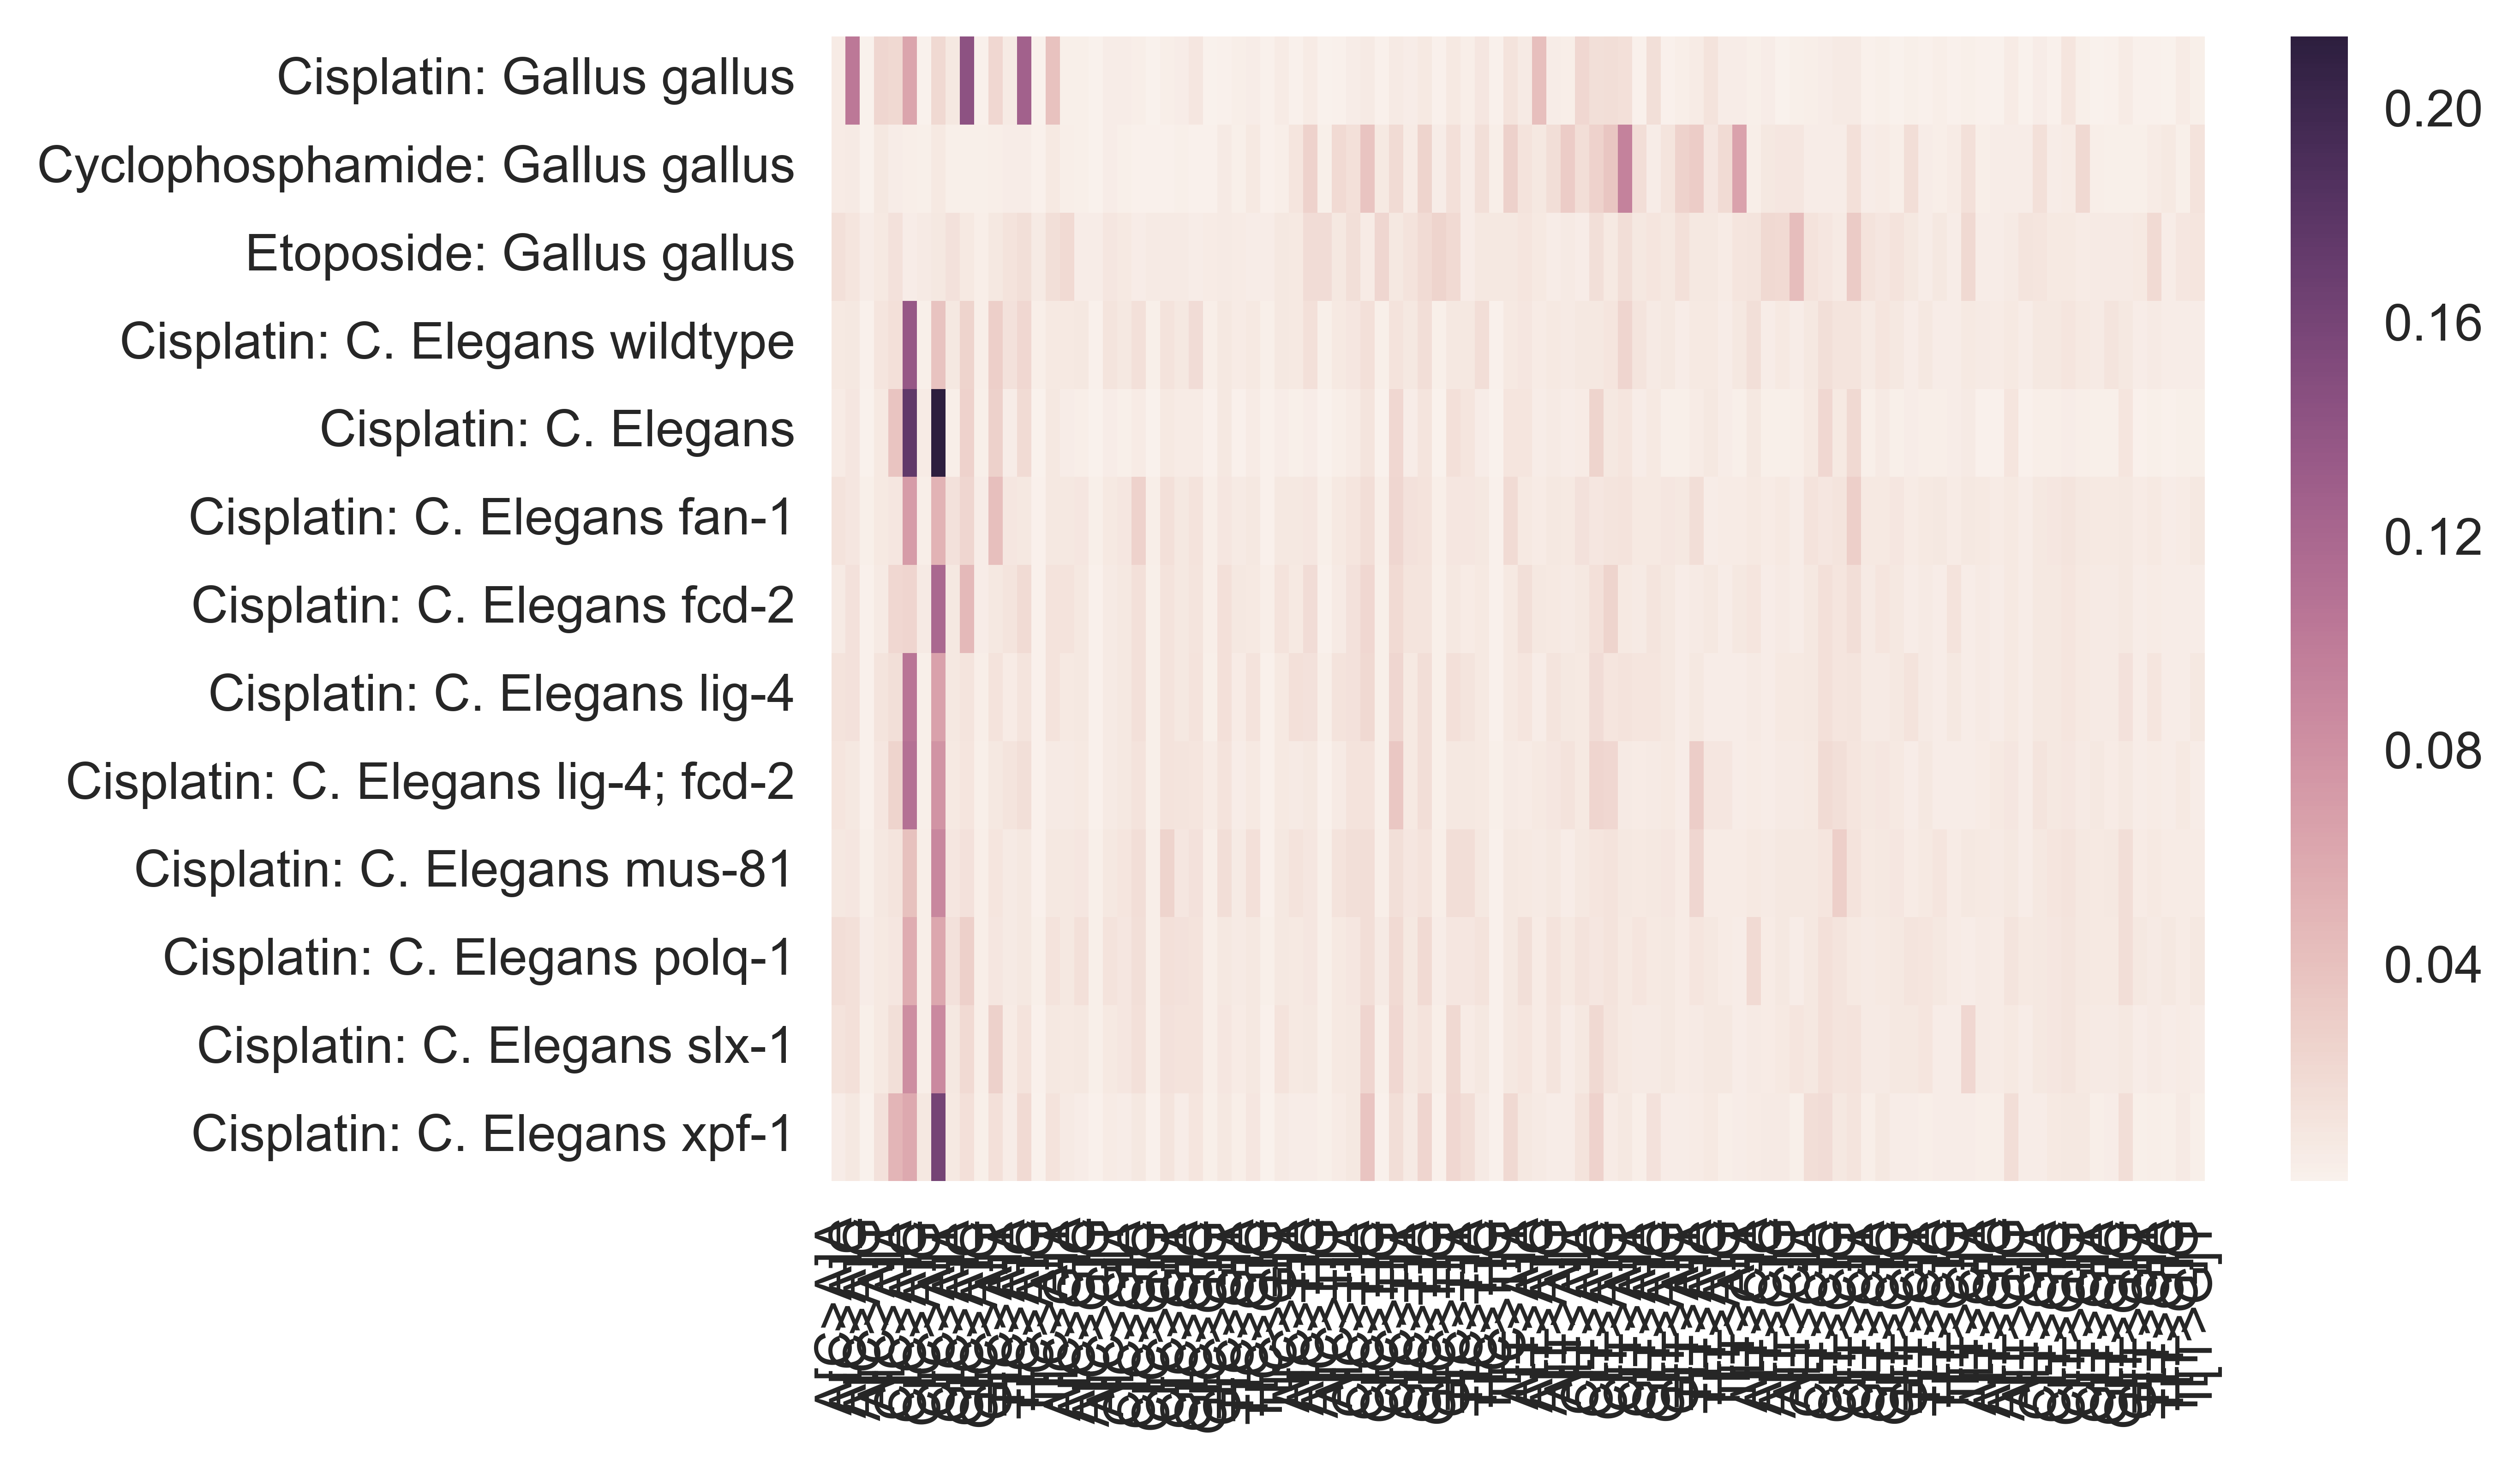

In [15]:
seaborn.heatmap(human_normalized_rates_canonicalized)

In [16]:
cosmic_signatures = pandas.read_table("../data/signatures_probabilities.txt", index_col="Somatic Mutation Type")
del cosmic_signatures["Substitution Type"]
del cosmic_signatures["Trinucleotide"]
cosmic_signatures = cosmic_signatures.dropna(1)
cosmic_signatures

,Signature 1,Signature 2,Signature 3,Signature 4,Signature 5,Signature 6,Signature 7,Signature 8,Signature 9,Signature 10,Signature 11,Signature 12,Signature 13,Signature 14,Signature 15,Signature 16,Signature 17,Signature 18,Signature 19,Signature 20,Signature 21,Signature 22,Signature 23,Signature 24,Signature 25,Signature 26,Signature 27,Signature 28,Signature 29,Signature 30
Somatic Mutation Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A[C>A]A,0.011098,6.827082e-04,0.022172,0.0365,0.014942,0.0017,0.0004,0.036718,0.0120,0.0007,0.0002,0.0077,3.347572e-04,0.0001,0.0013,0.0161,0.001832,5.053642e-02,0.0107,1.179962e-03,0.0001,0.001504,0.000453,0.028646,0.009897,2.039773e-03,0.005206,0.001397,0.069982,0.000000
A[C>A]C,0.009149,6.191072e-04,0.017872,0.0309,0.008961,0.0028,0.0005,0.033246,0.0067,0.0010,0.0010,0.0047,6.487361e-04,0.0042,0.0040,0.0097,0.000342,1.093982e-02,0.0074,2.211505e-03,0.0007,0.002451,0.000367,0.020215,0.006999,1.487162e-03,0.004738,0.000917,0.055152,0.000000
A[C>A]G,0.001490,9.927896e-05,0.002138,0.0183,0.002208,0.0005,0.0000,0.002525,0.0005,0.0003,0.0000,0.0017,3.814459e-05,0.0005,0.0000,0.0022,0.000002,2.288073e-03,0.0005,1.616910e-07,0.0000,0.000000,0.000000,0.020479,0.001448,2.839456e-04,0.000783,0.000000,0.017847,0.001967
A[C>A]T,0.006234,3.238914e-04,0.016265,0.0243,0.009207,0.0019,0.0004,0.033599,0.0068,0.0092,0.0002,0.0046,8.466585e-04,0.0296,0.0057,0.0088,0.003180,1.942409e-02,0.0074,3.008010e-03,0.0006,0.000922,0.000000,0.024600,0.004967,5.978656e-04,0.002718,0.000513,0.026805,0.000000
A[C>G]A,0.001801,2.634810e-04,0.024003,0.0097,0.011671,0.0013,0.0000,0.008357,0.0048,0.0005,0.0007,0.0031,3.775165e-03,0.0001,0.0011,0.0048,0.001662,1.516888e-03,0.0058,6.970411e-04,0.0005,0.000528,0.000000,0.011993,0.008033,1.272881e-03,0.001324,0.000255,0.009302,0.000000
A[C>G]C,0.002581,2.698660e-04,0.012160,0.0054,0.007292,0.0012,0.0000,0.004306,0.0023,0.0003,0.0003,0.0015,9.208248e-04,0.0000,0.0001,0.0024,0.001627,2.498785e-03,0.0019,2.059310e-03,0.0008,0.000000,0.000000,0.008425,0.001636,1.528195e-03,0.001771,0.000269,0.003479,0.000000
A[C>G]G,0.000593,2.192339e-04,0.005275,0.0031,0.002304,0.0000,0.0000,0.000584,0.0000,0.0000,0.0000,0.0000,1.989049e-05,0.0000,0.0006,0.0000,0.000026,2.614509e-03,0.0000,1.273496e-05,0.0000,0.000000,0.000000,0.000000,0.000000,3.072463e-04,0.000000,0.000000,0.000154,0.004820
A[C>G]T,0.002964,6.109735e-04,0.023278,0.0054,0.011696,0.0018,0.0001,0.008635,0.0038,0.0002,0.0009,0.0025,3.860632e-03,0.0001,0.0010,0.0073,0.001329,3.983011e-03,0.0072,8.485871e-04,0.0018,0.000299,0.000000,0.003881,0.003428,2.498252e-03,0.001323,0.000308,0.003977,0.000000
A[C>T]A,0.029515,7.441557e-03,0.017872,0.0120,0.021839,0.0312,0.0000,0.018067,0.0093,0.0000,0.0225,0.0121,1.480181e-03,0.0293,0.0117,0.0135,0.009350,3.825624e-03,0.0221,3.285805e-02,0.0051,0.003113,0.019767,0.006316,0.020988,5.907232e-03,0.013723,0.005434,0.005197,0.065119


In [17]:
all_signatures = cosmic_signatures.copy()
for col in human_normalized_rates_canonicalized.index:
    all_signatures[col] = human_normalized_rates_canonicalized.ix[col]
all_signatures.T.to_csv("../data/derived/all_signatures.csv", float_format="%0.8f")
all_signatures
    

,Signature 1,Signature 2,Signature 3,Signature 4,Signature 5,Signature 6,Signature 7,Signature 8,Signature 9,Signature 10,Signature 11,Signature 12,Signature 13,Signature 14,Signature 15,Signature 16,Signature 17,Signature 18,Signature 19,Signature 20,Signature 21,Signature 22,Signature 23,Signature 24,Signature 25,Signature 26,Signature 27,Signature 28,Signature 29,Signature 30,Cisplatin: Gallus gallus,Cyclophosphamide: Gallus gallus,Etoposide: Gallus gallus,Cisplatin: C. Elegans wildtype,Cisplatin: C. Elegans,Cisplatin: C. Elegans fan-1,Cisplatin: C. Elegans fcd-2,Cisplatin: C. Elegans lig-4,Cisplatin: C. Elegans lig-4; fcd-2,Cisplatin: C. Elegans mus-81,Cisplatin: C. Elegans polq-1,Cisplatin: C. Elegans slx-1,Cisplatin: C. Elegans xpf-1
Somatic Mutation Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A[C>A]A,0.011098,6.827082e-04,0.022172,0.0365,0.014942,0.0017,0.0004,0.036718,0.0120,0.0007,0.0002,0.0077,3.347572e-04,0.0001,0.0013,0.0161,0.001832,5.053642e-02,0.0107,1.179962e-03,0.0001,0.001504,0.000453,0.028646,0.009897,2.039773e-03,0.005206,0.001397,0.069982,0.000000,0.005793,0.005456,0.014940,0.007367,0.005393,0.012738,0.006910,0.013607,0.010568,0.008536,0.017507,0.012093,0.003991
A[C>A]C,0.009149,6.191072e-04,0.017872,0.0309,0.008961,0.0028,0.0005,0.033246,0.0067,0.0010,0.0010,0.0047,6.487361e-04,0.0042,0.0040,0.0097,0.000342,1.093982e-02,0.0074,2.211505e-03,0.0007,0.002451,0.000367,0.020215,0.006999,1.487162e-03,0.004738,0.000917,0.055152,0.000000,0.103328,0.006880,0.011079,0.008826,0.009904,0.009662,0.014258,0.014413,0.007899,0.010113,0.014594,0.014868,0.009072
A[C>A]G,0.001490,9.927896e-05,0.002138,0.0183,0.002208,0.0005,0.0000,0.002525,0.0005,0.0003,0.0000,0.0017,3.814459e-05,0.0005,0.0000,0.0022,0.000002,2.288073e-03,0.0005,1.616910e-07,0.0000,0.000000,0.000000,0.020479,0.001448,2.839456e-04,0.000783,0.000000,0.017847,0.001967,0.000460,0.001063,0.004514,0.001921,0.000914,0.002204,0.001909,0.001912,0.001764,0.002358,0.004818,0.002007,0.001098
A[C>A]T,0.006234,3.238914e-04,0.016265,0.0243,0.009207,0.0019,0.0004,0.033599,0.0068,0.0092,0.0002,0.0046,8.466585e-04,0.0296,0.0057,0.0088,0.003180,1.942409e-02,0.0074,3.008010e-03,0.0006,0.000922,0.000000,0.024600,0.004967,5.978656e-04,0.002718,0.000513,0.026805,0.000000,0.023322,0.008658,0.007311,0.010768,0.007491,0.007506,0.006759,0.011712,0.010164,0.008092,0.007481,0.007090,0.014235
A[C>G]A,0.001801,2.634810e-04,0.024003,0.0097,0.011671,0.0013,0.0000,0.008357,0.0048,0.0005,0.0007,0.0031,3.775165e-03,0.0001,0.0011,0.0048,0.001662,1.516888e-03,0.0058,6.970411e-04,0.0005,0.000528,0.000000,0.011993,0.008033,1.272881e-03,0.001324,0.000255,0.009302,0.000000,0.002787,0.003045,0.019554,0.007173,0.004086,0.007959,0.012055,0.007131,0.006577,0.008374,0.007843,0.007498,0.006233
A[C>G]C,0.002581,2.698660e-04,0.012160,0.0054,0.007292,0.0012,0.0000,0.004306,0.0023,0.0003,0.0003,0.0015,9.208248e-04,0.0000,0.0001,0.0024,0.001627,2.498785e-03,0.0019,2.059310e-03,0.0008,0.000000,0.000000,0.008425,0.001636,1.528195e-03,0.001771,0.000269,0.003479,0.000000,0.002303,0.002265,0.004189,0.008852,0.003183,0.009534,0.008452,0.008326,0.007764,0.010063,0.014715,0.009365,0.004685
A[C>G]G,0.000593,2.192339e-04,0.005275,0.0031,0.002304,0.0000,0.0000,0.000584,0.0000,0.0000,0.0000,0.0000,1.989049e-05,0.0000,0.0006,0.0000,0.000026,2.614509e-03,0.0000,1.273496e-05,0.0000,0.000000,0.000000,0.000000,0.000000,3.072463e-04,0.000000,0.000000,0.000154,0.004820,0.000316,0.001071,0.004916,0.001980,0.000673,0.002194,0.001952,0.001913,0.001833,0.002356,0.002176,0.002063,0.001694
A[C>G]T,0.002964,6.109735e-04,0.023278,0.0054,0.011696,0.0018,0.0001,0.008635,0.0038,0.0002,0.0009,0.0025,3.860632e-03,0.0001,0.0010,0.0073,0.001329,3.983011e-03,0.0072,8.485871e-04,0.0018,0.000299,0.000000,0.003881,0.003428,2.498252e-03,0.001323,0.000308,0.003977,0.000000,0.003911,0.003682,0.010142,0.011660,0.004896,0.007667,0.006966,0.006947,0.006352,0.007944,0.012106,0.007101,0.005978
A[C>T]A,0.029515,7.441557e-03,0.017872,0.0120,0.021839,0.

In [20]:
main_signatures = all_signatures[[c for c in all_signatures.columns if c == 'Cisplatin: C. Elegans' or 'Cisplatin: C. Elegans' not in c]]
main_signatures.T.to_csv("../data/derived/main_signatures.csv", float_format="%0.8f")
main_signatures

,Signature 1,Signature 2,Signature 3,Signature 4,Signature 5,Signature 6,Signature 7,Signature 8,Signature 9,Signature 10,Signature 11,Signature 12,Signature 13,Signature 14,Signature 15,Signature 16,Signature 17,Signature 18,Signature 19,Signature 20,Signature 21,Signature 22,Signature 23,Signature 24,Signature 25,Signature 26,Signature 27,Signature 28,Signature 29,Signature 30,Cisplatin: Gallus gallus,Cyclophosphamide: Gallus gallus,Etoposide: Gallus gallus,Cisplatin: C. Elegans
Somatic Mutation Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A[C>A]A,0.011098,6.827082e-04,0.022172,0.0365,0.014942,0.0017,0.0004,0.036718,0.0120,0.0007,0.0002,0.0077,3.347572e-04,0.0001,0.0013,0.0161,0.001832,5.053642e-02,0.0107,1.179962e-03,0.0001,0.001504,0.000453,0.028646,0.009897,2.039773e-03,0.005206,0.001397,0.069982,0.000000,0.005793,0.005456,0.014940,0.005393
A[C>A]C,0.009149,6.191072e-04,0.017872,0.0309,0.008961,0.0028,0.0005,0.033246,0.0067,0.0010,0.0010,0.0047,6.487361e-04,0.0042,0.0040,0.0097,0.000342,1.093982e-02,0.0074,2.211505e-03,0.0007,0.002451,0.000367,0.020215,0.006999,1.487162e-03,0.004738,0.000917,0.055152,0.000000,0.103328,0.006880,0.011079,0.009904
A[C>A]G,0.001490,9.927896e-05,0.002138,0.0183,0.002208,0.0005,0.0000,0.002525,0.0005,0.0003,0.0000,0.0017,3.814459e-05,0.0005,0.0000,0.0022,0.000002,2.288073e-03,0.0005,1.616910e-07,0.0000,0.000000,0.000000,0.020479,0.001448,2.839456e-04,0.000783,0.000000,0.017847,0.001967,0.000460,0.001063,0.004514,0.000914
A[C>A]T,0.006234,3.238914e-04,0.016265,0.0243,0.009207,0.0019,0.0004,0.033599,0.0068,0.0092,0.0002,0.0046,8.466585e-04,0.0296,0.0057,0.0088,0.003180,1.942409e-02,0.0074,3.008010e-03,0.0006,0.000922,0.000000,0.024600,0.004967,5.978656e-04,0.002718,0.000513,0.026805,0.000000,0.023322,0.008658,0.007311,0.007491
A[C>G]A,0.001801,2.634810e-04,0.024003,0.0097,0.011671,0.0013,0.0000,0.008357,0.0048,0.0005,0.0007,0.0031,3.775165e-03,0.0001,0.0011,0.0048,0.001662,1.516888e-03,0.0058,6.970411e-04,0.0005,0.000528,0.000000,0.011993,0.008033,1.272881e-03,0.001324,0.000255,0.009302,0.000000,0.002787,0.003045,0.019554,0.004086
A[C>G]C,0.002581,2.698660e-04,0.012160,0.0054,0.007292,0.0012,0.0000,0.004306,0.0023,0.0003,0.0003,0.0015,9.208248e-04,0.0000,0.0001,0.0024,0.001627,2.498785e-03,0.0019,2.059310e-03,0.0008,0.000000,0.000000,0.008425,0.001636,1.528195e-03,0.001771,0.000269,0.003479,0.000000,0.002303,0.002265,0.004189,0.003183
A[C>G]G,0.000593,2.192339e-04,0.005275,0.0031,0.002304,0.0000,0.0000,0.000584,0.0000,0.0000,0.0000,0.0000,1.989049e-05,0.0000,0.0006,0.0000,0.000026,2.614509e-03,0.0000,1.273496e-05,0.0000,0.000000,0.000000,0.000000,0.000000,3.072463e-04,0.000000,0.000000,0.000154,0.004820,0.000316,0.001071,0.004916,0.000673
A[C>G]T,0.002964,6.109735e-04,0.023278,0.0054,0.011696,0.0018,0.0001,0.008635,0.0038,0.0002,0.0009,0.0025,3.860632e-03,0.0001,0.0010,0.0073,0.001329,3.983011e-03,0.0072,8.485871e-04,0.0018,0.000299,0.000000,0.003881,0.003428,2.498252e-03,0.001323,0.000308,0.003977,0.000000,0.003911,0.003682,0.010142,0.004896
A[C>T]A,0.029515,7.441557e-03,0.017872,0.0120,0.021839,0.0312,0.0000,0.018067,0.0093,0.0000,0.0225,0.0121,1.480181e-03,0.0293,0.0117,0.0135,0.009350,3.825624e-03,0.0221,3.285805e-02,0.0051,0.003113,0.019767,0.006316,0.020988,5.907232e-03,0.013723,0.005434,0.005197,0.065119,0.001760,0.010673,0.007054,0.002629


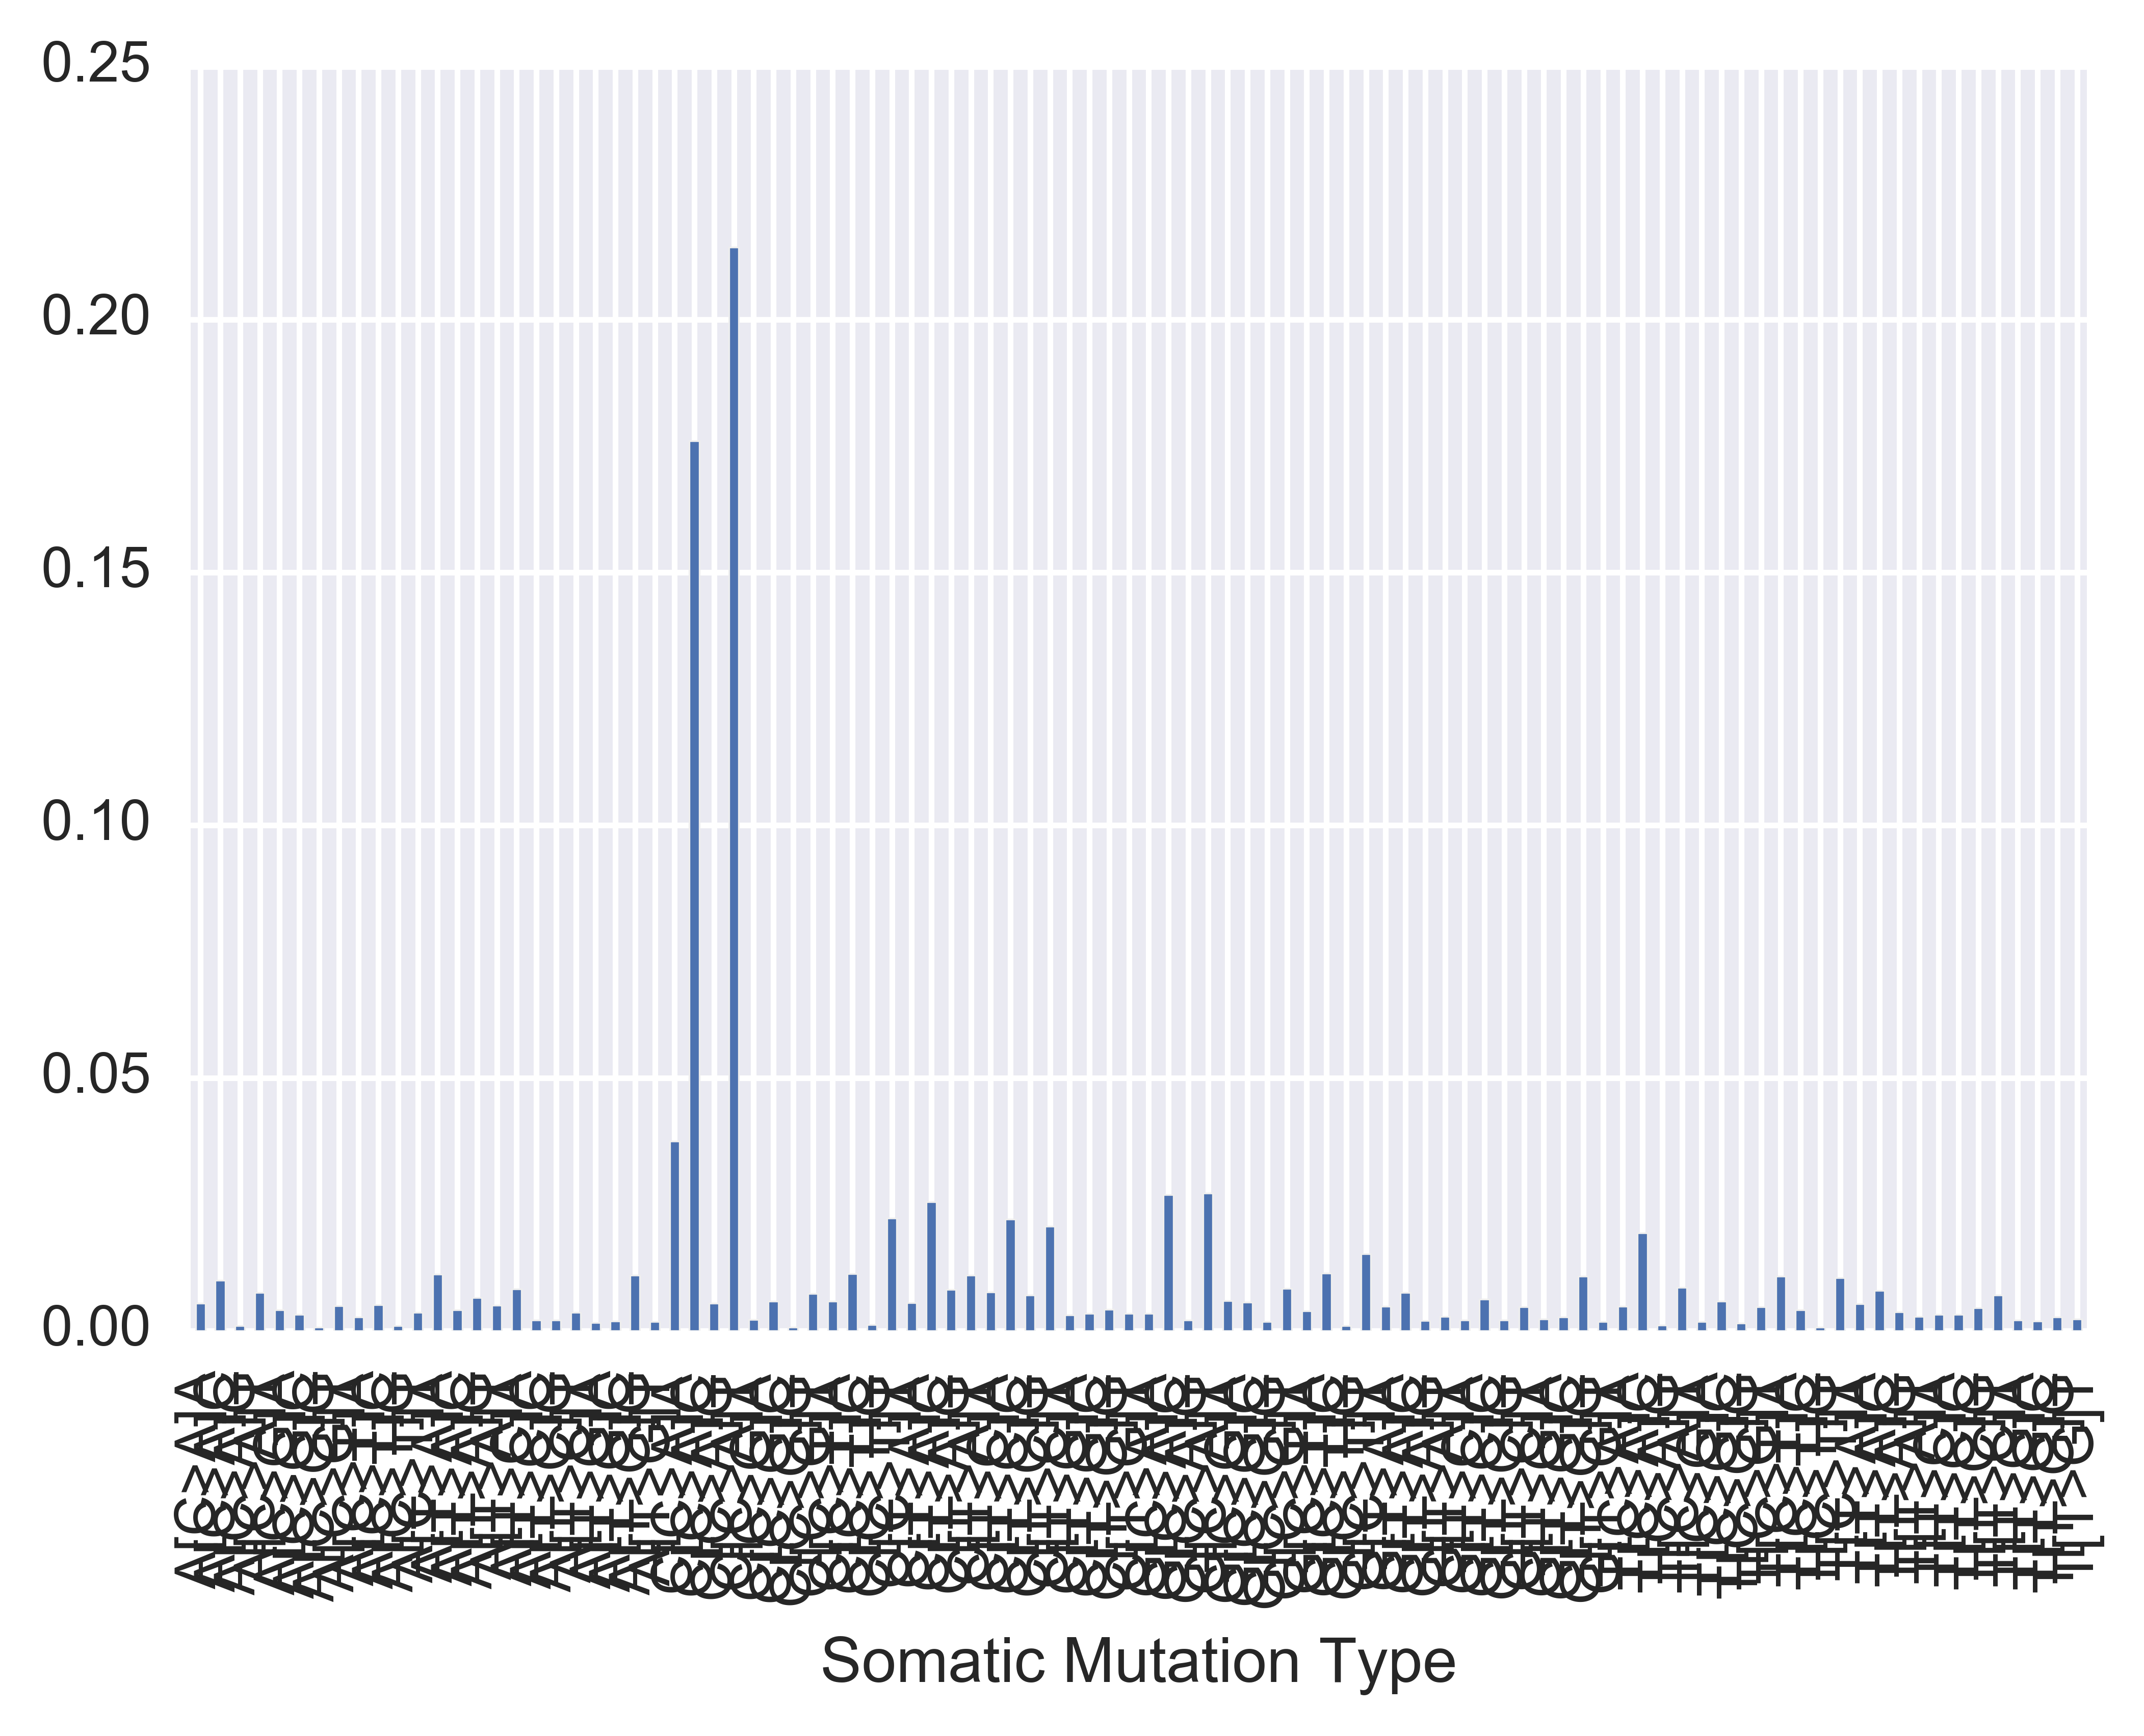

In [21]:
main_signatures["Cisplatin: C. Elegans"].plot(kind='bar')

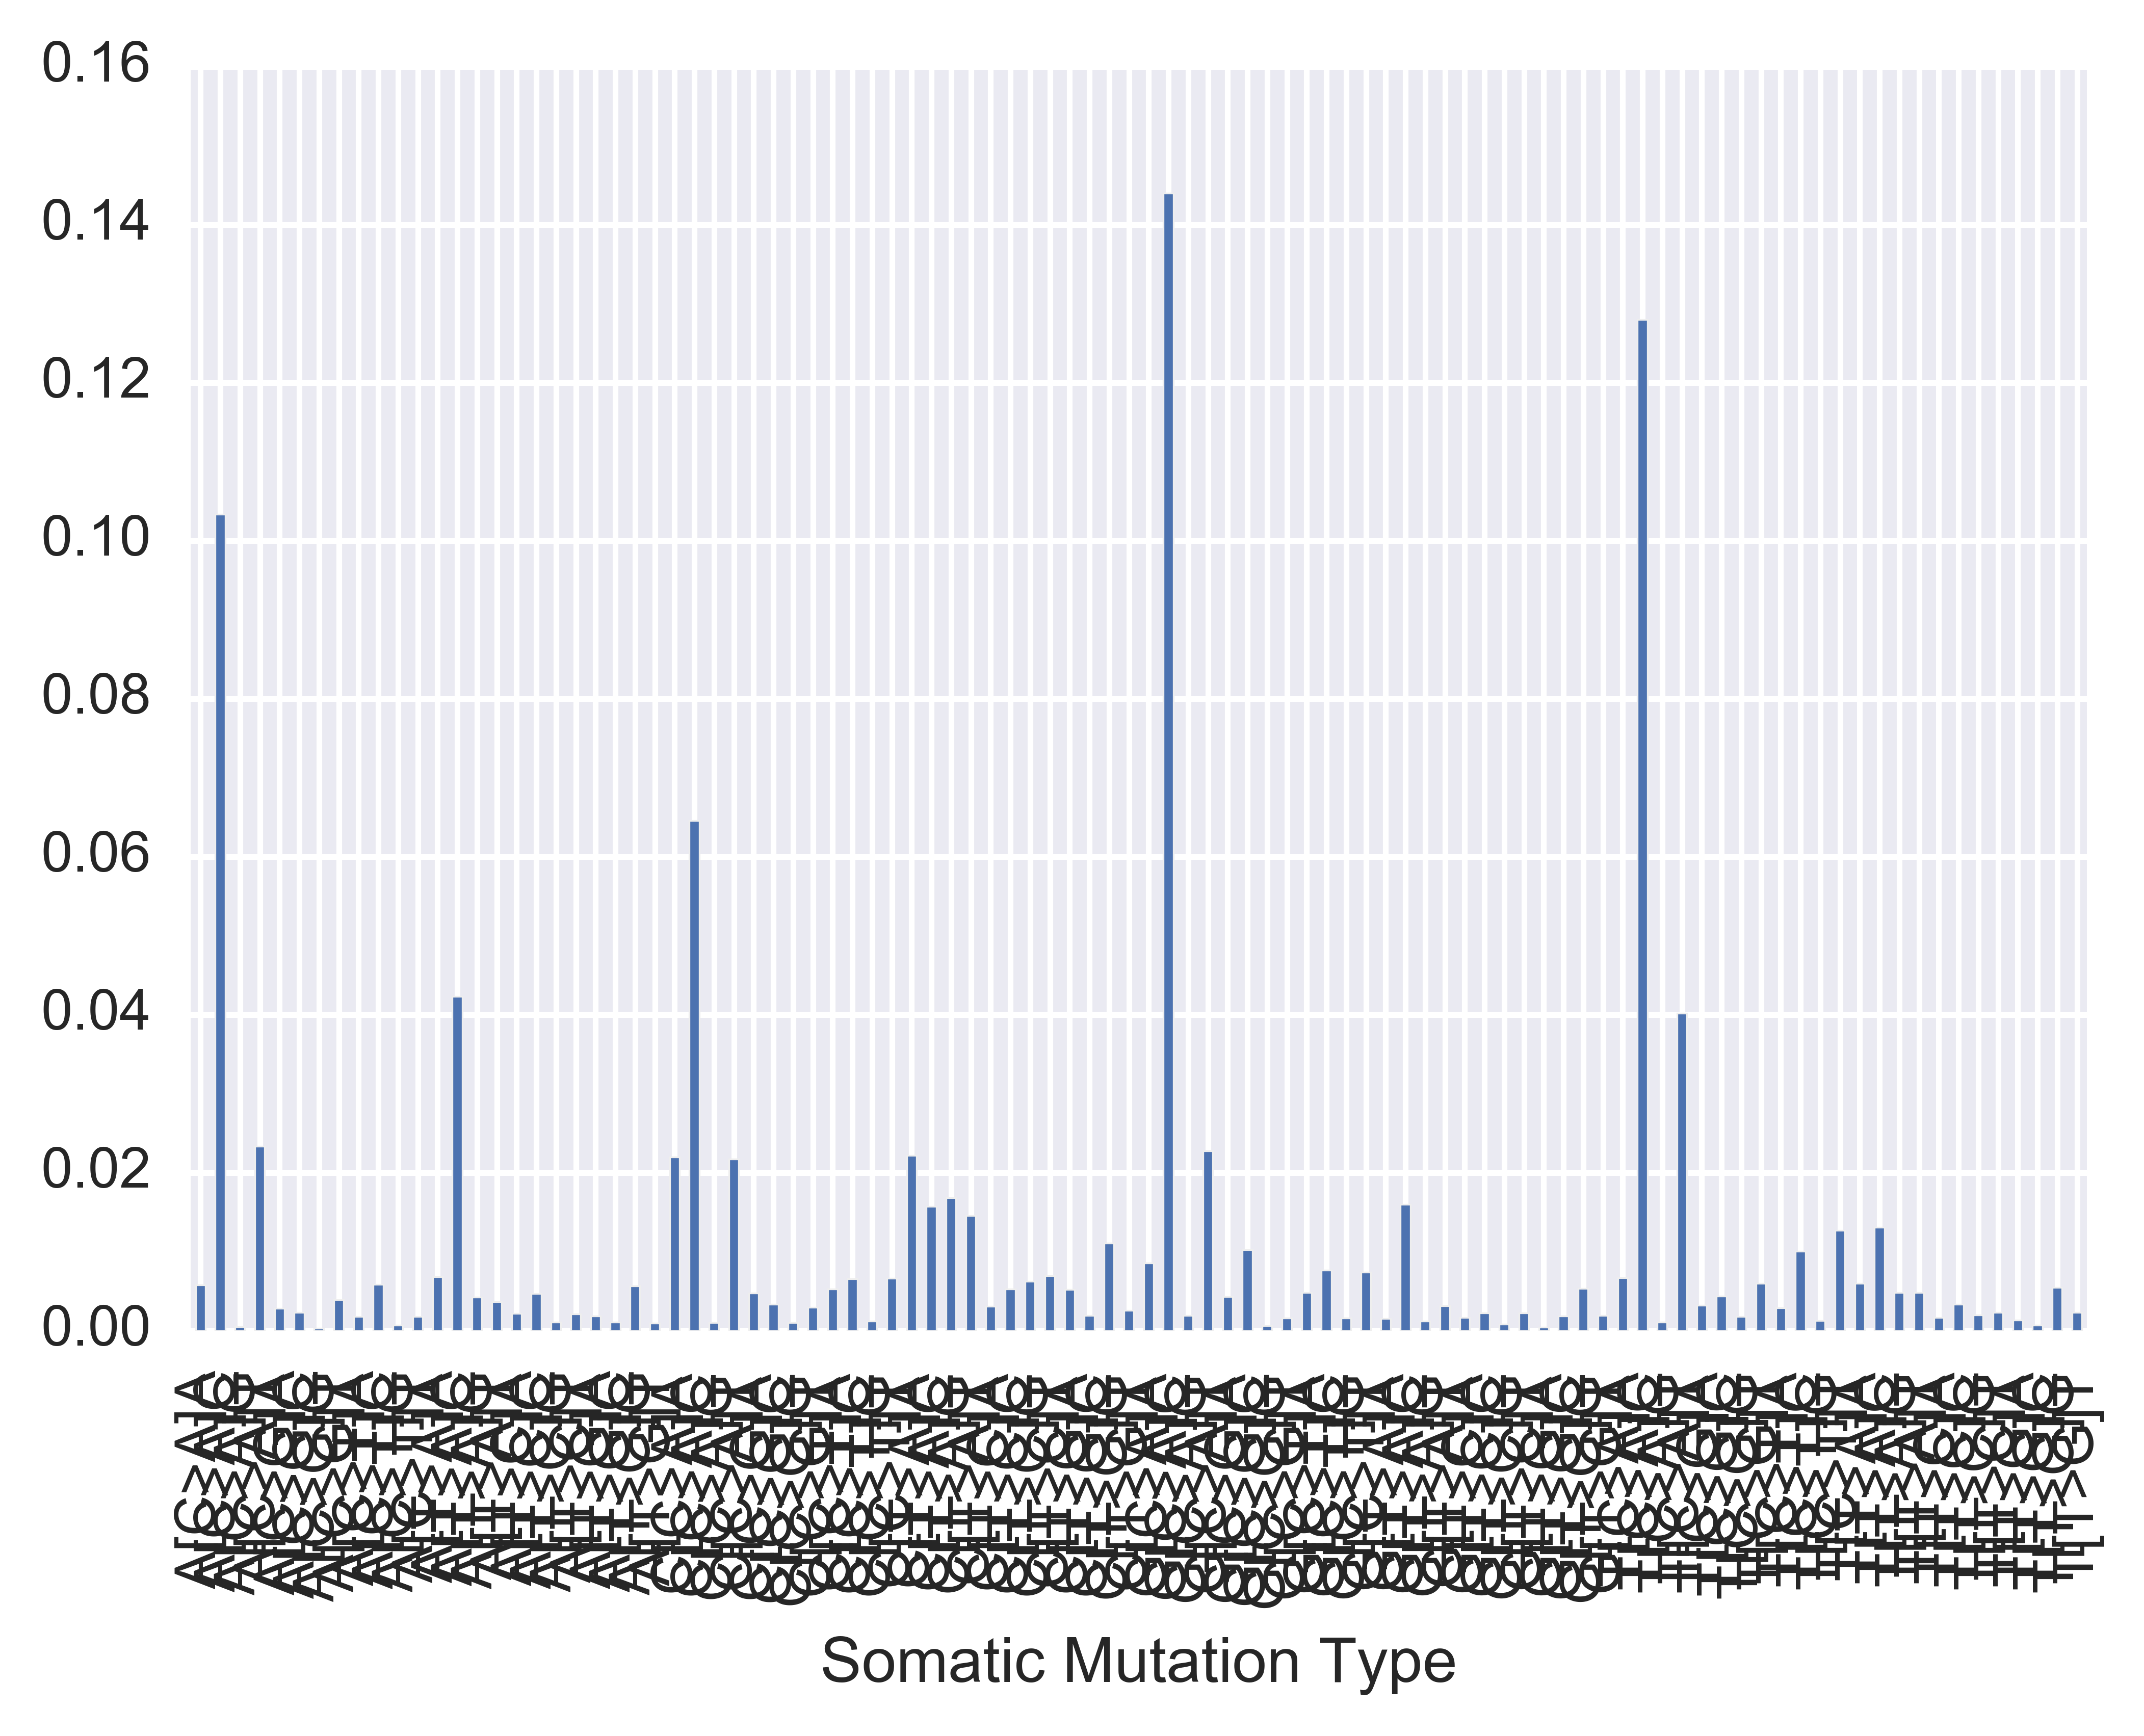

In [22]:
main_signatures["Cisplatin: Gallus gallus"].plot(kind='bar')